In [1]:
# pip를 사용하여 Pillow 라이브러리를 설치
# Pillow는 이미지 처리 및 조작을 위한 Python 라이브러리
!pip install pillow


In [11]:
from PIL import Image  # 이미지 처리 및 조작을 위한 Pillow 라이브러리
import os               # 운영체제 관련 기능 사용 (파일/폴더 처리)
import numpy as np      # 수치 계산 및 배열 처리를 위한 NumPy

data_dir = "./images/"  # 이미지가 저장될 폴더 경로 지정

# 폴더 확인 및 없으면 생성
if not os.path.exists(data_dir):   # 지정한 경로가 존재하지 않으면
    os.makedirs(data_dir)          # 폴더 생성
    print(f"폴더가 없어서 생성: {data_dir}")
else:
    print(f"폴더 존재: {data_dir}")  # 이미 폴더가 존재하면 알림

# 이미지 불러오기 및 전처리
images = []  # 이미지 데이터를 저장할 리스트 생성
for file in os.listdir(data_dir):  # 폴더 안의 모든 파일 반복
    path = os.path.join(data_dir, file)  # 파일 경로 생성
    # 이미지 파일만 처리 (숨김 폴더, 체크포인트, 비이미지 파일 무시)
    if os.path.isfile(path) and file.lower().endswith(('.png', '.jpg', '.jpeg')):
        img = Image.open(path).convert('L')  # 이미지 열기 및 흑백 변환 ('L' 모드)
        img = img.resize((28, 28))           # 모든 이미지를 28x28 크기로 리사이즈
        img_array = np.array(img) / 255.0    # NumPy 배열로 변환 후 0~1 범위로 정규화
        images.append(img_array)             # 리스트에 저장

# 리스트를 NumPy 배열로 변환
images = np.array(images)
print("이미지 배열 크기:", images.shape)  # 전체 이미지 배열 크기 출력

# CNN 모델 입력용 4차원 배열 변환
if images.size > 0:                           # 이미지가 존재할 때만
    images_4d = images.reshape(-1, 28, 28, 1)  # (배치, 높이, 너비, 채널) 형태로 변환
    print("4차원 CNN 입력용 배열 크기:", images_4d.shape)  # 변환 후 크기 출력


폴더 존재: ./images/
이미지 배열 크기: (4, 28, 28)
4차원 CNN 입력용 배열 크기: (4, 28, 28, 1)


In [12]:
import numpy as np
import tensorflow as tf

# images: 기존에 불러온 흑백 이미지 배열 (shape: [num_images, 28, 28])

# 1️⃣ 28x28 흑백 이미지를 224x224x3 RGB로 변환
resized_images = np.zeros((len(images), 224, 224, 3), dtype=np.float32)  
# 모든 이미지를 담을 배열 생성, 3채널 RGB, 크기 224x224

for i in range(len(images)):
    # 흑백 이미지를 3채널로 복제
    img_rgb = np.stack([images[i]]*3, axis=-1)  # shape: 28x28x3
    # TensorFlow를 이용하여 224x224로 리사이즈
    resized_images[i] = tf.image.resize(img_rgb, [224, 224])

# 2️⃣ MobileNetV2 전처리
preprocessed_images = tf.keras.applications.mobilenet_v2.preprocess_input(resized_images)
# MobileNetV2가 요구하는 입력 범위와 스케일로 변환 (예: [-1,1])

print("전처리 완료 이미지 shape:", preprocessed_images.shape)
# 출력: (num_images, 224, 224, 3)


전처리 완료 이미지 shape: (4, 224, 224, 3)


In [13]:
# ImageNet 데이터셋으로 학습된 MobileNetV2 모델 불러오기
mobilenet_imagenet_model = tf.keras.applications.MobileNetV2(weights="imagenet")

# 전처리된 이미지 배열을 사용하여 예측 수행
y_pred = mobilenet_imagenet_model.predict(preprocessed_images)
# y_pred: 각 이미지에 대한 1000개 클래스 확률 배열 (shape: [num_images, 1000])

topk = 1  # 상위 1개 클래스만 확인
# 예측 결과를 사람이 읽을 수 있는 클래스 이름으로 변환
y_pred_top = tf.keras.applications.mobilenet_v2.decode_predictions(y_pred, top=topk)
# y_pred_top: [(imagenet_id, 클래스명, 확률)] 형태의 리스트


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


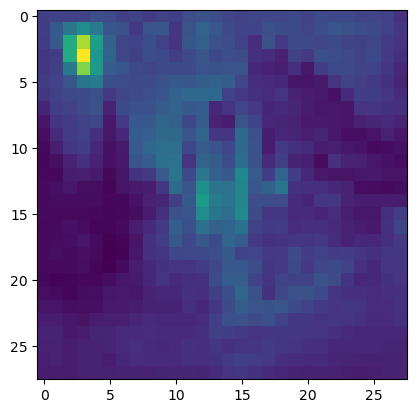

spotlight(31.299999237060547%)


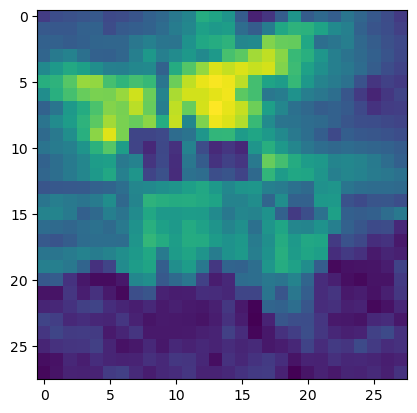

spotlight(30.299999237060547%)


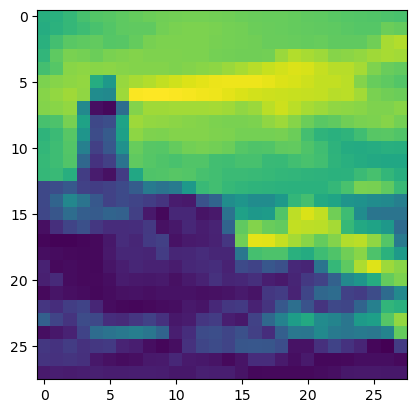

spotlight(30.5%)


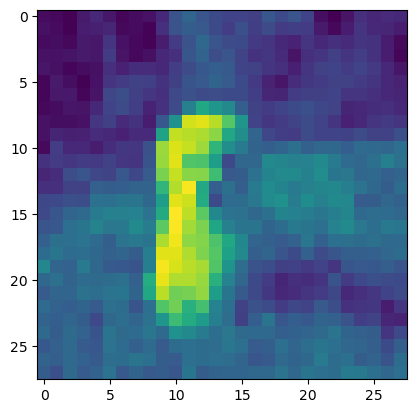

spotlight(31.299999237060547%)


In [14]:
from matplotlib import pyplot as plt  # 이미지 시각화를 위한 matplotlib
import numpy as np

topK = 5  # 출력할 상위 K개 예측

for i in range(len(images)):  
    plt.imshow(images[i])  # 원본 흑백 이미지 시각화
    plt.show()              # 이미지 표시

    # 실제 존재하는 예측 개수까지만 반복 (이미지 예측 결과가 topK보다 작을 수 있음)
    current_topK = min(topK, len(y_pred_top[i]))  
    
    for k in range(current_topK):  # 상위 current_topK 예측 출력
        # 클래스 이름과 확률(%) 출력
        print(f'{y_pred_top[i][k][1]}({round(y_pred_top[i][k][2] * 100, 1)}%)')
